In [5]:
# install dependencies
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install lxml
# %pip install scipy
# %pip install mplsoccer
# %pip install highlight-text
# %pip install ipywidgets
# %pip install ipympl

In [6]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from mplsoccer import PyPizza, add_image, FontManager
from highlight_text import fig_text

# %matplotlib ipympl
# %matplotlib widget
import ipywidgets as widgets

In [8]:
# filepath = 'fm24-data/data/v2/top6_leagues_cdm.html'
# filepath = 'fm24-data/data/v2/top6_leagues_wingers.html'
filepath = 'fm24-data/data/v2/top6_leagues_rb.html'

dfs = pd.read_html(filepath, encoding='utf8')
assert len(dfs) > 0 
df = dfs[0]
df.head()

,Rec,Inf,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist/90,Distance,Gl Mst,Tgls/90,Tcon/90,Av Rat
0,- - A+ -,Int,Runar Helle Hildre,23,71 kg,172 cm,NOR,Right,"D (RL), WB (R)",D (R),...,0.11,8.58,2.36,13.43,0.0mi,299.6mi,0,6.69,2.45,6.99
1,- - A+ -,Int,Genar Fortet,22,75 kg,181 cm,ESP,Right,"D (RL), WB/M/AM (R)",D (R),...,0.08,8.76,2.89,14.95,0.0mi,103.3mi,0,3.99,1.41,6.78
2,- - A+ -,Int,Iván Fresneda,27,75 kg,184 cm,ESP,Right,D/WB (R),D (R),...,0.61,8.78,2.58,13.02,0.0mi,348.6mi,0,6.25,3.31,7.24
3,- - A -,Int,Mikel Merino,21,79 kg,185 cm,ESP,Right,"D (RC), WB (R), M (C)",D (R),...,0.49,7.96,2.24,11.85,0.0mi,304.6mi,1,2.76,2.66,7.07
4,- - A -,NaN,Trent Alexander-Arnold,33,69 kg,180 cm,ENG,Right,"D/WB (R), DM, M (RC)",D (R),...,0.23,9.64,3.25,13.97,0.0mi,364.3mi,1,4.90,3.78,6.90


In [9]:
print("Number of players:", df.shape[0])
print("Number of fields:", df.shape[1])

Number of players: 575
Number of fields: 62


In [10]:
print(df.columns)

Index(['Rec', 'Inf', 'Name', 'Age', 'Weight', 'Height', 'Nat',
       'Preferred Foot', 'Position', 'Best Pos', 'Club', 'Division', 'Salary',
       'Transfer Value', 'Mins', 'Gls', 'xG', 'Ast', 'xA', 'Gls/90', 'xG/90',
       'NP-xG/90', 'Shot/90', 'Shot %', 'Conv %', 'Asts/90', 'xA/90',
       'Ps A/90', 'Pas %', 'Ps C/90', 'Pr passes/90', 'OP-KP/90',
       'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90', 'Ch C/90', 'Drb/90',
       'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90', 'Tck/90', 'Tck W',
       'Tck A', 'Blk/90', 'Int/90', 'Clr/90', 'Fls', 'Aer A/90', 'Hdr %',
       'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90', 'Pres C/90',
       'Sprints/90', 'Dist/90', 'Distance', 'Gl Mst', 'Tgls/90', 'Tcon/90',
       'Av Rat'],
      dtype='object')


In [11]:
# data processing

# Copy dataframe
players = df.copy()

# 'Rec', 'Info' are not useful.
# 'Dist/90' are all 0.0s in the data, we are going to calculate Dist/90 from Dist (total distance)
players = players.drop(['Rec', 'Inf', 'Dist/90'], axis=1)

# Column categories
int_cols = ['Age', 'Mins', 'Gls', 'Ast']
percent_cols = ['Shot %', 'Conv %', 'Pas %', 'OP-Cr %', 'Tck R', 'Hdr %']
nonnumeric_cols = ['Name', 'Position', 'Club', 'Division', 'Nat', 'Preferred Foot', 'Salary', 'Transfer Value']

# Replace missing metrics with 0s
# Note: in Football Manager - ~ 0
players = players.replace('-', 0)

# Transform weight, height columns
players['Weight'] = players['Weight'].str.split().str[0]
players['Height'] = players['Height'].str.split().str[0]

# Transform salary column
players['Salary'] = players['Salary'].str.extract(r'£([\d,]+)\s*p/w')[0]
players['Salary'] = players['Salary'].str.replace(',', '').astype(float)

# Extract distance covered
players['Distance'] = players['Distance'].str.extract(r'([\d.]+)').astype(float)

# Convert % string to float
players[percent_cols] = players[percent_cols].apply(
    lambda x: pd.to_numeric(x.str.rstrip('%'), errors='coerce') / 100)

# Note: Replacing '-' with 0 interferes with how the values in percent columns are parsed, i.e "50%" and 0
# Therefore, we have to set the NaNs, originally '-' -> 0 -> np.nan, to 0
players[percent_cols] = players[percent_cols].replace(np.nan, 0)

# Convert to correct types
for col in players.columns:
    if col not in (nonnumeric_cols + int_cols):
        players[col] = pd.to_numeric(players[col], errors='coerce')
    if col in int_cols:
        players[col] = pd.to_numeric(players[col], errors='coerce').astype(int)

# Filter out players with 0 minutes
players = players[players['Mins'] > 0]

# Normalize Distance Covered and Fouls 
players['Dist/90'] = round(players['Distance'] / players['Mins'] * 90, 2)
players['Fls/90'] = round(players['Fls'] / players['Mins'] * 90, 2)

players = players.drop(['Distance', 'Fls'], axis=1)

# Display the first few rows
players.head()

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90
0,Runar Helle Hildre,23,71,172,NOR,Right,"D (RL), WB (R)",NaN,FC Bayern,Bundesliga,...,0.11,8.58,2.36,13.43,0,6.69,2.45,6.99,7.95,1.35
1,Genar Fortet,22,75,181,ESP,Right,"D (RL), WB/M/AM (R)",NaN,Barcelona,Spanish First Division,...,0.08,8.76,2.89,14.95,0,3.99,1.41,6.78,8.30,1.93
2,Iván Fresneda,27,75,184,ESP,Right,D/WB (R),NaN,Juventus,Italian Serie A,...,0.61,8.78,2.58,13.02,0,6.25,3.31,7.24,7.82,1.23
3,Mikel Merino,21,79,185,ESP,Right,"D (RC), WB (R), M (C)",NaN,A. Bilbao,Spanish First Division,...,0.49,7.96,2.24,11.85,1,2.76,2.66,7.07,7.50,0.99
4,Trent Alexander-Arnold,33,69,180,ENG,Right,"D/WB (R), DM, M (RC)",NaN,Liverpool,English Premier Division,...,0.23,9.64,3.25,13.97,1,4.90,3.78,6.90,8.47,1.28


In [12]:
# Utility functions

def categorize_positions(positions):
    
    pos_groups = set()
    s1 = positions.split(',')
    for p in s1:
        s2 = p.split()

        # edge case
        if s2[0] == 'GK':
            pos_groups.add('Goalkeepers')
            continue
        if s2[0] == 'DM':
            pos_groups.add('Midfielders')
            continue

        s3 = s2[0].split('/')   # D WB M AM ST
        s4 = s2[1].strip('()')  # R L C

        if 'D' in s3 and 'C' in s4:
            pos_groups.add('Centerbacks')
        if any(x in s3 for x in ['D', 'WB']) and any(x in s4 for x in ['R', 'L']):
            pos_groups.add('Fullbacks')
        if any(x in s3 for x in ['DM', 'M']) and 'C' in s4:
            pos_groups.add('Midfielders')
        if any(x in s3 for x in ['M', 'AM']) and any(x in s4 for x in ['R', 'L']) or \
            ('AM' in s3 and 'C' in s4):
            pos_groups.add('Att Mid/Wingers')
        if 'ST' in s3:
            pos_groups.add('Forwards')

    return list(pos_groups)

In [14]:
# Display CDMs for Bournemouth
players[players['Club'] == 'Bournemouth']

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90
168,Darren Rye,24,84,180,ENG,Right,D (RC),NaN,Bournemouth,English Premier Division,...,0.22,9.53,3.14,14.12,1,6.69,3.16,7.08,8.33,1.40
171,Enoch Mastoras,26,72,174,NED,Right,"D (RC), WB (R), DM, M (R)",NaN,Bournemouth,English Premier Division,...,0.11,9.56,3.37,18.09,1,6.53,2.12,7.06,8.50,0.95


In [15]:
players.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Best Pos', 'Club', 'Division', 'Salary', 'Transfer Value', 'Mins',
       'Gls', 'xG', 'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90',
       'Shot %', 'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Tck W', 'Tck A', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90',
       'Hdr %', 'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90',
       'Pres C/90', 'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat',
       'Dist/90', 'Fls/90'],
      dtype='object')

In [16]:
# Only consider players who have played 450 or more in total minutes (~5 full matches)
players = players[players['Mins'] >= 450]

In [17]:
display(players.groupby('Division')['Division'].count())

Division
Bundesliga                  35
English Premier Division    45
Eredivisie                  32
Italian Serie A             36
Ligue 1 Uber Eats           27
Spanish First Division      39
Name: Division, dtype: int64

In [18]:
# Add team possession

epl = {
    'Arsenal': 58,
    'Aston Villa': 54,
    'Blackburn': 39,
    'Bournemouth': 55,
    'Brentford': 54,
    'Brighton': 45,
    'Chelsea': 39,
    'Everton': 49,
    'Leeds': 53,
    'Liverpool': 56,
    'Man City': 56,
    'Man UFC': 50,
    'Newcastle': 53,
    'Norwich': 49,
    'Nottm Forest': 46,
    'Reading': 36,
    'Southampton': 54,
    'Sunderland': 47,
    'Tottenham': 49,
    'West Ham': 47
}

bundesliga = {
    '1. FC Köln': 50,
    'Augsburg': 49,
    'Bayer 04': 51,
    'Borussia Dortmund': 58,
    'Borussia M\'gladbach': 50,
    'Eintracht Frankfurt': 48,
    'FC Bayern': 61,
    'HSV': 45,
    'Hannover': 41,
    'Heidenheim': 44,
    'Hertha BSC': 46,
    'Mainz 05': 44,
    'RB Leipzig': 56,
    'SC Freiburg': 51,
    'SV Werder': 48,
    'Schalke 04': 50,
    'VfB Stuttgart': 46,
}


la_liga = {
    'A. Bilbao': 52,
    'A. Madrid': 58,
    'Alavés': 47,
    'Almería': 45,
    'Atlético Pamplona': 48,
    'Barcelona': 54,
    'Cádiz': 43,
    'Elche': 37,
    'Espanyol': 46,
    'Girona': 49,
    'Granada': 43,
    'Levante': 45,
    'R. Madrid': 65,
    'Real San Sebastián': 51,
    'Sevilla': 56,
    'Valencia': 50,
    'Villarreal': 56,
    'Zaragoza': 42
}

serie_a = {
    'AC Milan': 58,
    'AS Roma': 48,
    'Atalanta': 48,
    'Bologna': 52,
    'Brianza': 50,
    'Cagliari': 50,
    'Empoli': 44,
    'Fiorentina': 55,
    'Frosinone': 49,
    'Genoa': 42,
    'Hellas Verona': 39,
    'Inter': 55,
    'Juventus': 58,
    'Lazio': 54,
    'Modena': 43,
    'Parthenope': 55,
    'Pisa': 46,
    'Sampdoria': 46,
    'Sassuolo': 52,
    'Udinese': 48
}

eredivisie = {
    'AZ': 56,
    'Ajax': 60,
    'Excelsior': 42,
    'FC Eindhoven': 45,
    'FC Twente': 40,
    'FC Utrecht': 57,
    'FC Volendam': 43,
    'Feyenoord': 58,
    'Fortuna Sittard': 48,
    'Go Ahead Eagles': 45,
    'N.E.C. Nijmegen': 47,
    'PEC Zwolle': 47,
    'PSV': 58,
    'RKC Waalwijk': 47,
    'Sparta Rotterdam': 50,
    'Vitesse': 50,
    'sc Heerenveen': 51
}

ligue_1 = {
    'AJ Auxerre': 42,
    'AS Monaco': 58,
    'ASSE': 51,
    'Bordeaux': 42,
    'Grenoble': 47,
    'LOSC': 52,
    'Montpellier': 47,
    'OGC Nice': 51,
    'OL': 49,
    'Paris SG': 62,
    'RC Lens': 51,
    'Reims': 46,
    'Rennes': 51,
    'Strasbourg': 56,
    'Toulouse FC': 52,
    'Troyes': 41,
    'VAFC': 46
}


# Defensive Actions
# Pressures

leagues_poss = {**epl, **bundesliga, **la_liga, **serie_a, **eredivisie, **ligue_1}
leagues_poss_df = pd.DataFrame(list(leagues_poss.items()), columns=['Club', 'Team Poss'])

if 'Team Poss' not in players.columns:
    players = pd.merge(players, leagues_poss_df, on='Club', how='left')

players['Team Poss'] = players['Team Poss'] / 100

display(players)

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90,Team Poss
0,Runar Helle Hildre,23,71,172,NOR,Right,"D (RL), WB (R)",NaN,FC Bayern,Bundesliga,...,8.58,2.36,13.43,0,6.69,2.45,6.99,7.95,1.35,0.61
1,Genar Fortet,22,75,181,ESP,Right,"D (RL), WB/M/AM (R)",NaN,Barcelona,Spanish First Division,...,8.76,2.89,14.95,0,3.99,1.41,6.78,8.30,1.93,0.54
2,Iván Fresneda,27,75,184,ESP,Right,D/WB (R),NaN,Juventus,Italian Serie A,...,8.78,2.58,13.02,0,6.25,3.31,7.24,7.82,1.23,0.58
3,Mikel Merino,21,79,185,ESP,Right,"D (RC), WB (R), M (C)",NaN,A. Bilbao,Spanish First Division,...,7.96,2.24,11.85,1,2.76,2.66,7.07,7.50,0.99,0.52
4,Trent Alexander-Arnold,33,69,180,ENG,Right,"D/WB (R), DM, M (RC)",NaN,Liverpool,English Premier Division,...,9.64,3.25,13.97,1,4.90,3.78,6.90,8.47,1.28,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Ben Johnson,32,66,183,NED,Right,"D (RL), WB (R)",NaN,FC Utrecht,Eredivisie,...,8.35,2.71,14.04,0,6.46,3.98,7.03,7.72,0.79,0.57
210,Neco Williams,31,72,183,WAL,Right,"D/WB (RL), M/AM (R)",NaN,Nottm Forest,English Premier Division,...,9.54,2.39,17.57,0,1.28,2.82,6.85,8.46,1.01,0.46
211,Brandon Williams,31,63,182,ENG,Right,D/WB (RL),NaN,1. FC Köln,Bundesliga,...,9.36,3.14,13.73,1,4.52,5.85,6.81,7.79,1.58,0.50
212,Vontae Daley-Campbell,31,78,183,JAM,Right,"D (RC), WB (R)",NaN,Fortuna Sittard,Eredivisie,...,9.14,2.43,15.54,0,0.82,1.36,6.92,7.90,0.75,0.48


In [19]:
# Additional metrics

# Defensive Actions
# "Def Acts/90" - defensive actions per 90
# > ‘defensive actions’ that are used in the calculation are tackles,
# > challenges (failed tackles), interceptions, and fouls per 90

# XG Overperformance
players['Gls - xG/90'] = players['Gls/90'] - players['xG/90']

# Net Possession Won
players['Net Poss Won/90'] = players['Poss Won/90'] - players['Poss Lost/90']

# Tck/90 is Tackle Made Per 90, thus we recalculate Tackle Attempts per 90 (FM24 doesn't have this stat)
players['Tck A/90'] = round(players['Tck/90'] / players['Tck R'], 2)
players['Def Acts/90'] = players['Tck A/90'] + players['Int/90'] + players['Fls/90']

players[['Name', 'Tck A/90', 'Def Acts/90', 'Net Poss Won/90', 'Gls - xG/90']].sort_values('Gls - xG/90', ascending=False)
# players[['Name', 'Def Acts/90']].sort_values('Def Acts/90', ascending=False).head(10)

,Name,Tck A/90,Def Acts/90,Net Poss Won/90,Gls - xG/90
186,Simone Restelli,2.75,5.60,-15.36,0.21
190,José Amat,2.40,7.01,-10.88,0.14
179,Gede Riyanto,3.49,7.20,-7.39,0.12
46,Million Manhoef,3.40,5.88,-7.83,0.10
110,Álvaro Mantilla,3.91,8.05,1.50,0.09
...,...,...,...,...,...
31,Benjamin White,3.28,6.24,4.11,-0.14
159,Achraf Ben Salah,2.82,5.99,-3.17,-0.14
147,Emanuel,1.09,3.11,-18.32,-0.15
145,Landry Farré,3.10,7.43,-7.02,-0.16


In [20]:
# Create possession-adjusted metrics

# out-of-possession metrics
out_padj_metrics = ['Poss Won/90', 'Def Acts/90', 'Pres A/90']
# in-possession metrics
in_padj_metrics = ['Pr passes/90', 'Drb/90', 'Ps A/90', 'Poss Lost/90']

for metric in in_padj_metrics:
    players[f'pAdj {metric}'] = round(players[metric] / players['Team Poss'] * 0.5, 2)
for metric in out_padj_metrics:
    players[f'pAdj {metric}'] = round(players[metric] / (1 - players['Team Poss']) * 0.5, 2)

players.head()

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Best Pos,Club,Division,...,Net Poss Won/90,Tck A/90,Def Acts/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90
0,Runar Helle Hildre,23,71,172,NOR,Right,"D (RL), WB (R)",NaN,FC Bayern,Bundesliga,...,9.79,2.93,7.31,5.51,1.79,49.09,4.57,19.71,9.37,11.00
1,Genar Fortet,22,75,181,ESP,Right,"D (RL), WB/M/AM (R)",NaN,Barcelona,Spanish First Division,...,-8.44,3.91,8.41,5.73,1.04,48.29,16.74,10.48,9.14,9.52
2,Iván Fresneda,27,75,184,ESP,Right,D/WB (R),NaN,Juventus,Italian Serie A,...,9.17,3.06,6.76,6.85,1.41,54.78,5.98,19.18,8.05,10.45
3,Mikel Merino,21,79,185,ESP,Right,"D (RC), WB (R), M (C)",NaN,A. Bilbao,Spanish First Division,...,9.65,2.94,6.42,6.87,1.44,49.40,6.63,17.24,6.69,8.29
4,Trent Alexander-Arnold,33,69,180,ENG,Right,"D/WB (R), DM, M (RC)",NaN,Liverpool,English Premier Division,...,2.71,3.80,7.40,7.71,1.06,56.19,8.95,14.47,8.41,10.95


# Scouting Criteria: Defensive Midfielder - Segundo Volante on Support

## Scope
- Players who are natural at DM.
- Players who play in Europe to 6 leagues.
- Players who have played more than 900 minutes (around 10 full matches, ensuring sufficient sample size)

## Requirements
- Players who are 28 or younger.
- 

## Metrics
- Pass Attempts/90 (is player involved in build up)
- Pass C Ratio (is player good at passing)
- Progressive Pass/90 (is player progressive)
- Open-play key pass/90 (is player creative? ~ rare)
- Poss Lost/90 (is player safe on ball)

### Defensive metrics
- Poss Won/90  (prioritize for defend, cover) 
- Tackle ratio (good tackler?)
- Defensive Actions/90 (tackles attempt, interceptions, fouls)

> Defensive Actions per StatsBomb definition
> The defensive actions that I am using are the following four Opta defined events:
> - Tackles
> - Interceptions
> - Challenges (failed tackles)
> - Fouls

### Aerial metrics

In [21]:
valid_cdms = players[players['Mins'] >= 450]    # played 5 or more full matches on average
valid_cdms.shape

valid_wingers = players[players['Mins'] >= 450]

In [22]:
# for col in valid_cdms.columns:
    # print(col)
# valid_cdms.columns
valid_wingers.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Best Pos', 'Club', 'Division', 'Salary', 'Transfer Value', 'Mins',
       'Gls', 'xG', 'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90',
       'Shot %', 'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Tck W', 'Tck A', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90',
       'Hdr %', 'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90',
       'Pres C/90', 'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat',
       'Dist/90', 'Fls/90', 'Team Poss', 'Gls - xG/90', 'Net Poss Won/90',
       'Tck A/90', 'Def Acts/90', 'pAdj Pr passes/90', 'pAdj Drb/90',
       'pAdj Ps A/90', 'pAdj Poss Lost/90', 'pAdj Poss Won/90',
       'pAdj Def Acts/90', 'pAdj Pres A/90'],
      dtype='object')

In [23]:
# DM metrics
params = [
    'NP-xG/90', 'Gls/90', 'Shot/90', 'xA/90', 'OP-KP/90', 'Ch C/90',           # Attacking
    # 'Pr passes/90', 'Drb/90', 'Ps A/90', 'Poss Lost/90',                     # Possession
    # 'Poss Won/90', 'Def Acts/90', 'Hdrs W/90', 'Pres A/90', 'Dist/90',       # Defending
    'pAdj Pr passes/90', 'pAdj Drb/90', 'pAdj Ps A/90', 'pAdj Poss Lost/90',
    'pAdj Poss Won/90', 'pAdj Def Acts/90', 'pAdj Pres A/90', 'Hdrs W/90', 'Hdr %', 'Dist/90',
]


# defensive actions
# Tck/90 + Int/90 + Fls/90

valid_cdms[params]

,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
0,0.05,0.05,0.37,0.09,0.69,0.62,5.51,1.79,49.09,4.57,19.71,9.37,11.00,1.09,0.38,7.95
1,0.04,0.00,0.32,0.13,0.96,0.58,5.73,1.04,48.29,16.74,10.48,9.14,9.52,1.04,0.41,8.30
2,0.05,0.07,0.36,0.14,0.79,0.63,6.85,1.41,54.78,5.98,19.18,8.05,10.45,4.00,0.63,7.82
3,0.09,0.07,1.08,0.10,0.69,0.47,6.87,1.44,49.40,6.63,17.24,6.69,8.29,3.92,0.65,7.50
4,0.04,0.05,0.42,0.16,1.19,0.92,7.71,1.06,56.19,8.95,14.47,8.41,10.95,2.53,0.52,8.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0.06,0.03,0.50,0.11,0.69,0.48,4.81,0.81,41.74,10.49,15.99,8.07,9.71,4.24,0.67,7.72
210,0.03,0.04,0.58,0.11,0.72,0.93,5.03,2.55,53.32,12.07,11.21,8.05,8.83,4.05,0.64,8.46
211,0.02,0.03,0.19,0.05,0.67,0.07,6.44,1.39,52.18,11.21,10.54,8.00,9.36,1.90,0.50,7.79
212,0.01,0.00,0.18,0.11,0.86,0.07,4.17,1.52,48.92,13.17,12.74,5.88,8.79,3.46,0.67,7.90


In [24]:
valid_cdms.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Best Pos', 'Club', 'Division', 'Salary', 'Transfer Value', 'Mins',
       'Gls', 'xG', 'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90',
       'Shot %', 'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Tck W', 'Tck A', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90',
       'Hdr %', 'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90',
       'Pres C/90', 'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat',
       'Dist/90', 'Fls/90', 'Team Poss', 'Gls - xG/90', 'Net Poss Won/90',
       'Tck A/90', 'Def Acts/90', 'pAdj Pr passes/90', 'pAdj Drb/90',
       'pAdj Ps A/90', 'pAdj Poss Lost/90', 'pAdj Poss Won/90',
       'pAdj Def Acts/90', 'pAdj Pres A/90'],
      dtype='object')

In [25]:
valid_cdms[['Name', 'pAdj Ps A/90']].sort_values(by='pAdj Ps A/90')

,Name,pAdj Ps A/90
204,Rasmus Kristensen,31.35
205,Alexander Bah,32.92
186,Simone Restelli,34.93
21,Leon Koß,35.16
147,Emanuel,35.98
...,...,...
80,Sergio Carreira,NaN
92,Alexandre Penetra,NaN
94,Tiago Santos,NaN
129,Xavi Grande,NaN


In [35]:
def find_percentiles(player_name):

    players = valid_cdms[valid_cdms['Name'] == player_name]
    if not len(players):
        return []

    player_stats = players[params].iloc[0]
    
    values = []
    for x in params:
        value = max(1, min(99, math.floor(stats.percentileofscore(valid_cdms[x], player_stats[x]))))

        if x == 'Poss Lost/90':
            value = min(99, 100 - value) 
        
        values.append(value)
    return values



In [36]:
# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#222222",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    last_circle_color="#222222",    # color of last circle
    other_circle_ls="-.",           # linestyle for other circles
    other_circle_lw=1               # linewidth for other circles
)

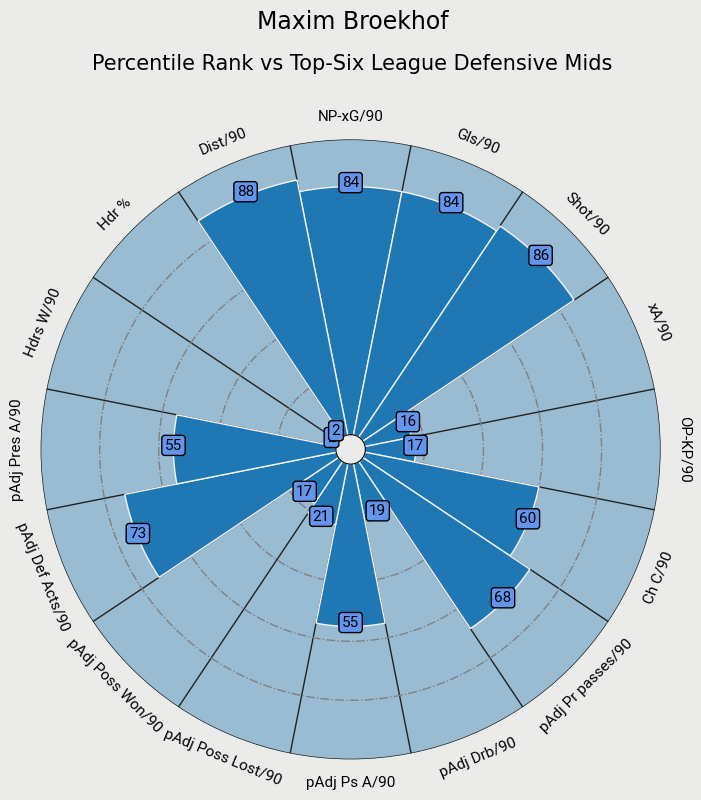

In [39]:
player_name = 'Maxim Broekhof'
# player_name = 'Lamine Yamal'
values = find_percentiles(player_name)

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

# color for the slices and text
# slice_colors = ["#1A78CF"] * 6 + ["#FF9300"] * 4 + ["#D70232"] * 6
# text_colors = ["#000000"] * 10 + ["#F2F2F2"] * 6

# plot pizza
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    # slice_colors=slice_colors,       # color for individual slices
    # value_colors=text_colors,        # color for the value-text
    # value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#F2F2F2", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values
)

# add title 
fig.text(
      0.515, 0.99, player_name, size=17,
      ha="center", color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Top-Six League Defensive Mids",
    size=15,
    ha="center", color="#000000"
)


plt.show()

In [40]:
valid_cdms[valid_cdms['Club'] == 'Sevilla']

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,Net Poss Won/90,Tck A/90,Def Acts/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90
19,David Luque,24,69,174,ESP,Left,"DM, M (LC), AM (C)",Sevilla,Spanish First Division,51000.0,...,4.71,2.49,4.99,3.87,1.00,45.41,7.34,14.69,5.67,13.17
149,Daniel Bragança,32,71,177,POR,Left,"DM, M (C)",Sevilla,Spanish First Division,39500.0,...,3.12,3.13,5.68,4.80,0.37,46.12,7.83,13.51,6.45,11.42
175,Anton Stach,33,84,193,GER,Right,"DM, M/AM (C)",Sevilla,Spanish First Division,42000.0,...,1.42,2.62,6.04,3.87,0.93,45.43,10.71,15.24,6.86,13.01
235,Kobbie Mainoo,27,70,181,ENG,Right,"DM, M (RC), AM (C)",Sevilla,Spanish First Division,29500.0,...,1.26,2.74,5.73,3.65,1.92,40.06,8.59,12.36,6.51,13.47


In [41]:
# valid_cdms['Poss Won/90'].sort_values()

display(valid_cdms[valid_cdms['Name'] == 'Archie Gray'][['Name'] + params])
display(valid_cdms[valid_cdms['Name'] == 'Manu Koné'][['Name'] + params])
display(valid_cdms[valid_cdms['Name'] == 'James Garner'][['Name'] + params])

np.percentile(valid_cdms['Poss Won/90'], 30)

,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
1,Archie Gray,0.11,0.13,1.02,0.16,0.96,1.24,4.01,1.01,44.92,4.71,18.69,6.79,12.86,1.93,0.53,8.14


,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
101,Manu Koné,0.12,0.05,0.91,0.2,1.65,2.43,3.88,1.89,48.4,7.42,10.2,8.31,11.32,1.81,0.52,8.72


,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
337,James Garner,0.07,0.13,1.44,0.18,1.26,1.38,6.66,0.58,55.17,7.25,11.07,6.43,12.09,1.54,0.51,8.43


np.float64(10.172)

In [42]:
cdm_names = valid_cdms['Name'].sort_values()

In [43]:
def createPizza(player_name):

    # values = valid_cdms[valid_cdms['Name'] == player_name][params]
    values = find_percentiles(player_name)

    baker = PyPizza(
        params=params,                  # list of parameters
        background_color="#EBEBE9",     # background color
        straight_line_color="#222222",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        last_circle_color="#222222",    # color of last circle
        other_circle_ls="-.",           # linestyle for other circles
        other_circle_lw=1               # linewidth for other circles
    )

    fig, ax = baker.make_pizza(
        values,                          # list of values
        figsize=(8, 8.5),                # adjust figsize according to your need
        color_blank_space="same",        # use same color to fill blank space
        slice_colors=slice_colors,       # color for individual slices
        value_colors=text_colors,        # color for the value-text
        value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        kwargs_slices=dict(
            edgecolor="#F2F2F2", zorder=2, linewidth=1
        ),                               # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, va="center"
        ),                               # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                                # values to be used when adding parameter-values
    )

    fig.text(
      0.515, 0.99, player_name, size=17,
      ha="center", color="#000000"
    )
    
    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Top-Six League Defensive Mids",
        size=15,
        ha="center", color="#000000"
    )
    
    plt.show()
    
widgets.interact(createPizza, player_name=cdm_names);

interactive(children=(Dropdown(description='player_name', options=('Abdullah Hekmat', 'Achraf el Bouchataoui',…

In [44]:
def create_compare_pizza(player_1, player_2):

    values_1 = find_percentiles(player_1)
    values_2 = find_percentiles(player_2)
    
    # plot pizza
    fig, ax = baker.make_pizza(
        values_1,                    # list of values
        compare_values=values_2,    # comparison values
        figsize=(8, 8),             # adjust figsize according to your need
        kwargs_slices=dict(
            facecolor="#1A78CF", edgecolor="#222222",
            zorder=2, linewidth=1
        ),                          # values to be used when plotting slices
        kwargs_compare=dict(
            facecolor="#FF9300", edgecolor="#222222",
            zorder=2, linewidth=1,
        ),
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                          # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        ),                          # values to be used when adding parameter-values labels
        kwargs_compare_values=dict(
            color="#000000", fontsize=12, fontproperties=font_normal.prop, zorder=3,
            bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
        ),                          # values to be used when adding parameter-values labels
    )

    # add title
    fig_text(
        0.515, 0.99, f"<{player_1}> vs <{player_2}>", size=17, fig=fig,
        highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    
    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Top-Six League Defensive Mids",
        size=12,
        ha="center", color="#000000"
    )

    plt.show()

    display(valid_cdms[(valid_cdms['Name'] == player_1) | (valid_cdms['Name'] == player_2)][['Name'] + params])

widgets.interact(create_compare_pizza, player_1=cdm_names, player_2=cdm_names);

interactive(children=(Dropdown(description='player_1', options=('Abdullah Hekmat', 'Achraf el Bouchataoui', 'A…

In [ ]:
# Players search

# kone_percentiles = find_percentiles('Manu Koné')
# print('Percentiles:')
# for i in range(len(params)):
#     print(f'{params[i]}: {kone_percentiles[i]}th')

metrics = params.copy()
# kone_stats = valid_cdms[valid_cdms['Name'] == 'Manu Koné'].iloc[0]
kone_percentiles = np.array(find_percentiles('James Garner'))
# print('Percentiles:')
# for i in range(len(params)):
#     print(f'{params[i]}: {kone_percentiles[i]}th')

# lower-bound: within -10 percentile of Kone stats
lower_bound_percentiles = kone_percentiles - 15
# lower_bound_percentiles

threshold = 11

lower_bound_stats = []
for i in range(len(metrics)):
    lower_bound_stats.append(np.percentile(valid_cdms[metrics[i]], lower_bound_percentiles[i]))

# comparison = valid_cdms[valid_cdms[params].ge(lower_bound_percentiles, axis=1)]
comparison = valid_cdms[metrics].ge(lower_bound_stats, axis=1)

# valid_cdms['Comparison'] = comparison.sum(axis=1)

# display(valid_cdms[['Name', 'Comparison']])


# parse transfer value (based, top value)


# Filter rows where the number of True values is greater than or equal to the threshold
rows_higher_than_reference = valid_cdms[(comparison.sum(axis=1) >= threshold) & (valid_cdms['Age'] <= 28) & (valid_cdms['Pr passes/90'] > 5)]
rows_higher_than_reference[['Name', 'Age', 'Club', 'Transfer Value']]

short-listed players:
- Archie Gray
- Kal-El Oliveira
- Matty Denham
- Jayce Fitzgerald
- Silvano Vos
- Lesley Ugochukwu
- Jordan James
- Kobbie Mainoo